### S1 hunting

For a specific event lets see if we can extract the correct s1.

The event in question today is: evt 618469 from run 14522! 

In [1]:
import sys,os,os.path
sys.path.append("../../") # if you move files around, you need to adjust this!
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize

pd.set_option('display.max_rows', 200)

import imageio

In [13]:

evt = 618469
file_path = '/home/e78368jw/Documents/NEXT_CODE/next_misc/alphas_muon_track/soph_data/run_14522_full_ldc1_trg0.v2.1.0.20241114.Alphas.sophronia.h5'

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,620759,1.730649e+09,0,-200.374713,-358.664832,1,243.225,-340.975,0.0,0.0,1.971250,11.927007,105.162328,-1.0,-1.0,-1,-1.0
1,620759,1.730649e+09,0,-200.374713,-358.664832,1,-220.275,-356.525,0.0,0.0,5.312500,5.814157,594.987466,-1.0,-1.0,-1,-1.0
2,620759,1.730649e+09,0,-200.374713,-358.664832,1,-189.175,-340.975,0.0,0.0,5.312500,5.073806,519.224264,-1.0,-1.0,-1,-1.0
3,620759,1.730649e+09,0,-200.374713,-358.664832,1,10.975,-386.625,0.0,0.0,5.312500,5.197725,531.905425,-1.0,-1.0,-1,-1.0
4,620759,1.730649e+09,0,-200.374713,-358.664832,1,-281.475,-340.475,0.0,0.0,9.162125,5.519236,82.230305,-1.0,-1.0,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712491,619087,1.730649e+09,0,-391.321797,-151.413853,1,243.225,-340.975,0.0,0.0,1263.272375,5.565937,34.641943,-1.0,-2.0,-1,-1.0
712492,619087,1.730649e+09,0,-391.321797,-151.413853,1,-220.275,-47.525,0.0,0.0,1267.182000,5.584566,3.340741,-1.0,-1.0,-1,-1.0
712493,619087,1.730649e+09,0,-391.321797,-151.413853,1,243.225,-340.975,0.0,0.0,1267.182000,8.746471,5.232224,-1.0,-1.0,-1,-1.0
712494,619087,1.730649e+09,0,-391.321797,-151.413853,1,-420.425,-140.325,0.0,0.0,1270.403125,7.402917,7.210163,-1.0,-1.0,-1,-1.0


618275 622792
Time spent in cut_over_Q: 0.012559652328491211 s
Time spent in drop_isolated: 0.037523508071899414 s


Text(0.5, 0.98, 'Processed Sensors Signal_618469')

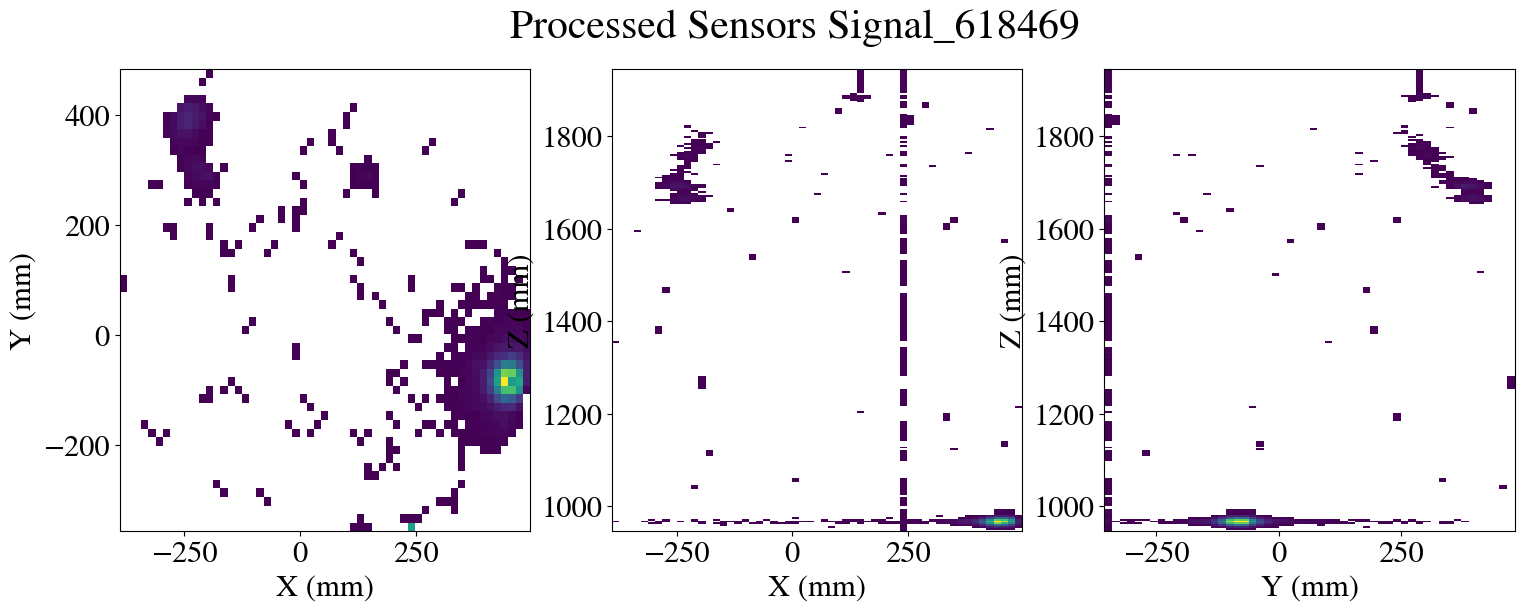

In [15]:
soph_hdst = dstio.load_dst(file_path, 'RECO', 'Events')#CHITS/lowTh
display(soph_hdst)
print(soph_hdst.event.min(), soph_hdst.event.max())
soph_hits = soph_hdst[soph_hdst.event == evt]


q_cut = 8
drop_dist       = [16, 16]
cut_sensors       = beerfun.cut_over_Q   (q_cut, ['E', 'Ec'])
drop_sensors      = beerfun.drop_isolated(drop_dist, ['E', 'Ec'])
hits_cut = coref.timefunc(cut_sensors)(soph_hits.copy())
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())
pitch = 15.55
# then applying transformations to convert to 'SiPM outputs'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))


xx = np.arange(hits_drop.X.min(), hits_drop.X.max() + pitch, pitch)
yy = np.arange(hits_drop.Y.min(), hits_drop.Y.max() + pitch, pitch)
zz = hits_cut.Z.unique()

axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

fig.suptitle('Processed Sensors Signal_' + str(evt), fontsize=30)


Look at `/DST/Events`:

In [18]:
soph_dst = dstio.load_dst(file_path, 'DST', 'Events')#CHITS/lowTh
soph_dst = soph_dst[soph_dst.event == evt]
display(soph_dst)

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
480,618469,1.730649e+09,0,0,1,1,725.0,226.491104,1303.30481,650250.0,...,2452,963.737671,963.737671,304.092,111.0944,12.966709,111.848564,0.116192,282.84422,230.042303
